# Word2Vec model

In [350]:
import spacy
import scispacy
import pickle
import numpy as np
import pandas as pd
import re
import en_ner_bionlp13cg_md
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('classic')

A list of tokenized sentences is needed for a Word2Vec model:

In [3]:
nlp = en_ner_bionlp13cg_md.load()

In [4]:
#tokenizer split on '/' also
infixes = nlp.Defaults.infixes + (r'''/''',)
infix_regex = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infix_regex.finditer

In [5]:
#merge identified entitites into chunks, this is important for multi-word proteins 
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)

In [21]:
#had turned on noun chunks but model was better with it disabled
merge_nouns = nlp.create_pipe("merge_noun_chunks")
nlp.add_pipe(merge_nouns)

In [65]:
#add the sentencizer pipe component from spacy
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [56]:
#define the keep token rules: the token needs to be more than 1 character and not a stop word
def keep_token(t):
    #return (t.ent_type != 0 or t.pos_ == "NOUN" or t.pos_ == "PROPN" or t.pos_ == "VERB") 
    return (t.__len__() > 1 and t.is_stop == False)

In [8]:
import os
os.chdir('/Volumes/BethMac/Metis Proj 4 data/')

In [9]:
with open('title_abstract_docs_list.pickle', 'rb') as read_file:
    abstracts = pickle.load(read_file)

In [10]:
len(abstracts)

337871

In [12]:
#remove new line characters from abstracts
abstracts = list(map(lambda x: re.sub('\\n',' ', x),abstracts))

In [71]:
nlp_abstracts = nlp.pipe(abstracts, disable=["parser","merge_nouns"])

In [72]:
#build the sentence tokens list
sentence_tokens = []
count = 0

for doc in nlp_abstracts:
    sentences = doc.sents
    for s in sentences:
        sentence_tokens.append([re.sub('[)(]|\-$','',t.lemma_.lower()) for t in s if keep_token(t)])
    count += 1
    if count%1000 == 0:
        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [75]:
#with open('sentence_tokens.pickle', 'wb') as write_file:
#    pickle.dump(sentence_tokens,write_file)

Train a small Word2Vec model. It's a CBOW model by default, and I used a window of 2 words on either side of the focus word and a vector size of 30. Words in less than 20 documents were excluded.

In [351]:
from gensim.models import Word2Vec

In [85]:
w2v_model = Word2Vec(sentence_tokens,
                     min_count=20,
                     window=2,
                     size=30,
                     workers=3)

In [240]:
#with open('w2v_model.pickle', 'wb') as write_file:
#    pickle.dump(w2v_model, write_file)

In [ ]:
with open('w2v_model.pickle', 'rb') as read_file:
    w2v_model = pickle.load(read_file)

Looked at similarities between words

In [465]:
w2v_model.wv.most_similar(positive=["antibody"])

[('mab', 0.9386519193649292),
 ('ab', 0.9287069439888),
 ('antiserum', 0.9049502611160278),
 ('moab', 0.8742688298225403),
 ('monoclonal', 0.845733642578125),
 ('scfv', 0.785213053226471),
 ('bispecific', 0.7512626647949219),
 ('scfvs', 0.7463455200195312),
 ('flc', 0.7452021241188049),
 ('gammopathy', 0.7422220706939697)]

In [354]:
#list of proteins related to miRNAs and mRNA modification
w2v_model.wv.most_similar(positive=["drosha"])

[('ago2', 0.9090682864189148),
 ('dicer', 0.9010425806045532),
 ('dgcr8', 0.8825297355651855),
 ('dicer1', 0.8360365033149719),
 ('auf1', 0.8236735463142395),
 ('sra', 0.8226485252380371),
 ('ogt', 0.8142427206039429),
 ('tsg101', 0.8045661449432373),
 ('adar1', 0.8012075424194336),
 ('hur', 0.8008813261985779)]

In [89]:
#list of steroids
w2v_model.wv.most_similar(positive=["androgen"])

[('estrogen', 0.9045140743255615),
 ('oestrogen', 0.836421549320221),
 ('progestin', 0.8155102729797363),
 ('ar', 0.8034884929656982),
 ('human androgen', 0.7988086938858032),
 ('progesterone', 0.7933131456375122),
 ('castration', 0.7886373400688171),
 ('antiestrogen', 0.783228874206543),
 ('androgen receptor', 0.7777259349822998),
 ('estradiol', 0.7774113416671753)]

In [466]:
#correct - caspase is not a transcription factor
w2v_model.wv.doesnt_match(['smad', 'stat', 'jun', 'creb','b-catenin', 'caspase'])

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'caspase'

In [339]:
#tgfb activates smad and jak activates stat
w2v_model.wv.most_similar(positive=['stat', 'tgfb'], negative=['smad'])

[('janus kinase', 0.8022024631500244),
 ('jak', 0.7566204071044922),
 ('ikbke', 0.7434075474739075),
 ('jak2-stat3', 0.7219303846359253),
 ('jak-stat', 0.7154008150100708),
 ('janus kinases', 0.71361243724823),
 ('janus tyrosine kinases', 0.7063664197921753),
 ('nod2-mediated', 0.7057802081108093),
 ('socs-1', 0.702123761177063),
 ('il1', 0.6968396306037903)]

In [95]:
#correct is 2nd choice, b-catenin
w2v_model.wv.most_similar(positive=['wnt', 'stat'], negative=['jak'])

[('notch', 0.8736619353294373),
 ('β-catenin', 0.8687324523925781),
 ('hh', 0.8641165494918823),
 ('beta-catenin', 0.845676064491272),
 ('hippo', 0.8436160683631897),
 ('hedgehog', 0.842531681060791),
 ('shh', 0.8196277022361755),
 ('bmp', 0.8134657144546509),
 ('pcp', 0.8090837001800537),
 ('hedgehog-gli', 0.8014574646949768)]

In [96]:
#correct is fourth choice - yap
w2v_model.wv.most_similar(positive=['hippo', 'smad'], negative=['tgfb'])

[('network', 0.7880990505218506),
 ('ddr', 0.7822858095169067),
 ('mtorc1', 0.774041473865509),
 ('yap', 0.7661123871803284),
 ('mtorc2', 0.7656790018081665),
 ('ras', 0.7572907209396362),
 ('torc1', 0.735136091709137),
 ('downstream', 0.7350701689720154),
 ('upstream', 0.7267253398895264),
 ('tor', 0.7166546583175659)]

In [108]:
#cAMP binds to PKA to activate it and calcium binds to cam kinase ii to activate it
w2v_model.wv.most_similar(positive=['calcium', 'pka'], negative=['camp'])

[('camkii', 0.8278478980064392),
 ('ca²⁺', 0.8230966329574585),
 ('ca2+', 0.8224935531616211),
 ('girk', 0.8108043670654297),
 ('kca3.1', 0.8071615099906921),
 ('katp', 0.8004486560821533),
 ('ip3 receptor', 0.8004202842712402),
 ('plasma membrane ca2+', 0.797620952129364),
 ('bkca', 0.7967962026596069),
 ('neuronal ca2+', 0.7962998747825623)]

In [110]:
#neuron is not an immune system cell
w2v_model.wv.doesnt_match(['t-cell', 'b-cell', 'macrophage','neutrophil','neuron'])

'neuron'

In [118]:
#histone is not a protein involved in adhesion
w2v_model.wv.doesnt_match(['integrin', 'cadherin', 'selectin', 'occludin', 'vcam', 'ncam', 'histone'])

'histone'

In [332]:
#second choice is right - inhibitory binding proteins
w2v_model.wv.most_similar(positive=['keap1', 'nfkb'], negative=['nrf2'])

[('nik', 0.8875367045402527),
 ('ikkα', 0.8703591823577881),
 ('cjun', 0.8479061126708984),
 ('rel', 0.8435419201850891),
 ('ikk-alpha', 0.8390546441078186),
 ('ikk2', 0.8384244441986084),
 ('ikkβ', 0.8378127217292786),
 ('ikkalpha', 0.8296139240264893),
 ('mekk4', 0.827118456363678),
 ('jak kinases', 0.8263416290283203)]

In [129]:
#first choice is right - transcription factor interactions
w2v_model.wv.most_similar(positive=['fos', 'β-catenin'], negative=['tcf'])

[('junb', 0.8578189015388489),
 ('jun', 0.8337555527687073),
 ('c-fos', 0.8277279734611511),
 ('fra-1', 0.8256969451904297),
 ('fra1', 0.8035809397697449),
 ('fosb', 0.8019673824310303),
 ('mapk3', 0.7997921705245972),
 ('protooncogene', 0.7941627502441406),
 ('fra-2', 0.791016161441803),
 ('smad 2', 0.7870793342590332)]

In [443]:
def display_pca_scatterplot(model, words_1, words_2):
    '''
    Plot words from two related lists in PCA dimensions 
    Connect the words at the same index in each list with a line
    '''
   
    words = words_1+words_2
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(10,10),frameon=False)
    plt.scatter(twodim[:len(words_1),0], twodim[:len(words_1),1], c=colors[0], s=50)
    for word, (x,y) in zip(words_1, twodim[0:len(words_1)]):
        plt.text(x+0.2, y-0.12, word, fontsize=17)
        
    plt.scatter(twodim[len(words_1):,0], twodim[len(words_1):,1], c=colors[1], s=50)
    for word, (x,y) in zip(words_2, twodim[len(words_1):]):
        plt.text(x+0.2, y-0.12, word, fontsize=17)
        
    for pos1, pos2 in zip(twodim[0:len(words_1)],twodim[len(words_1):]):
        plt.plot([pos1[0],pos2[0]],[pos1[1],pos2[1]],c='grey',alpha=0.6)
    

In [357]:
colors = plt.cm.cool(np.linspace(0,1,2)) 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


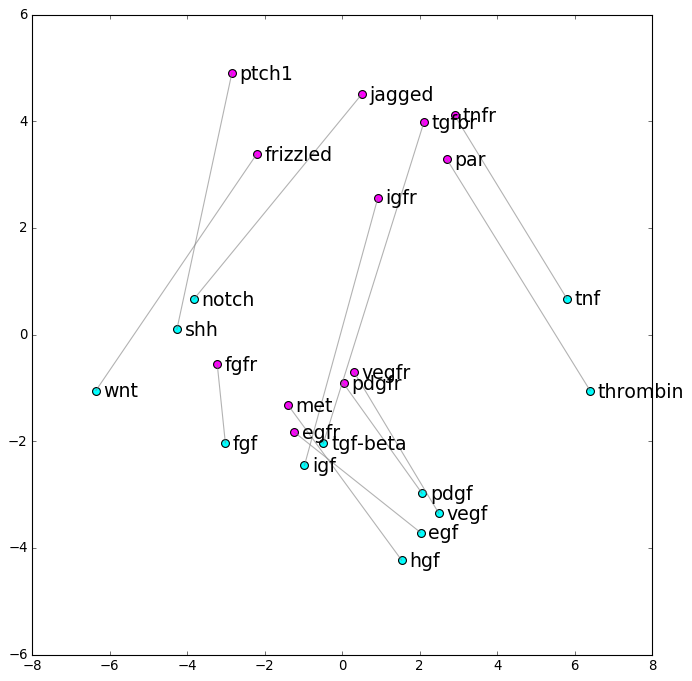

In [447]:
display_pca_scatterplot(w2v_model.wv, 
                        ['tgf-beta','shh','egf','vegf','fgf','pdgf','tnf','igf','thrombin','wnt','hgf','notch'],['tgfbr','ptch1','egfr','vegfr','fgfr','pdgfr','tnfr','igfr','par','frizzled','met','jagged'])

#plt.savefig('ligands_receptors_2.jpg')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


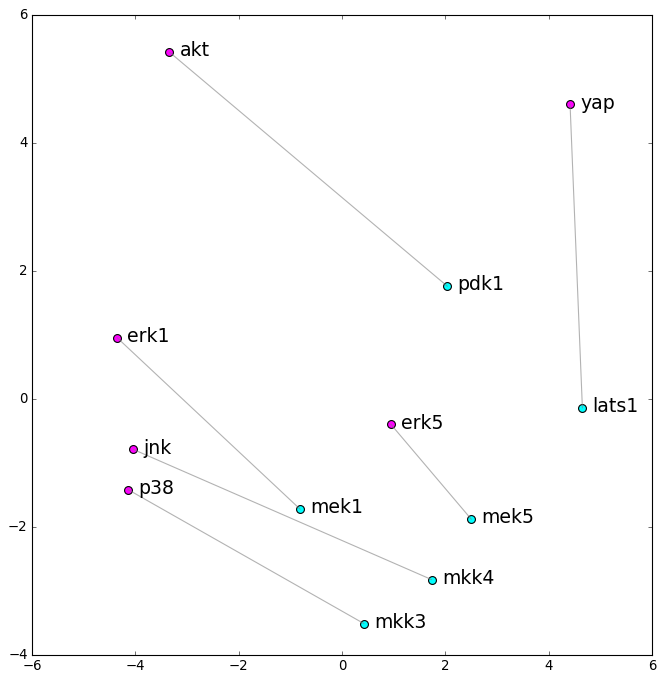

In [360]:
display_pca_scatterplot(w2v_model.wv, 
                        ['mek1','pdk1','mkk4','mkk3','mek5','lats1'],['erk1','akt','jnk','p38','erk5','yap'])
plt.savefig('kinases.jpg')

More word comparisons

In [218]:
#second choice is right
w2v_model.wv.most_similar(positive=['actin', 'tubulin'], negative=['f-actin'])

[('covalent', 0.8485742211341858),
 ('microtubule', 0.8032900094985962),
 ('hdac6', 0.7520396113395691),
 ('catalysis', 0.7511951923370361),
 ('sumo', 0.7480200529098511),
 ('isoprenylation', 0.7408669590950012),
 ('v-atpase', 0.739966869354248),
 ('p53-mdm2', 0.7331105470657349),
 ('cdk', 0.7321823835372925),
 ('intramolecular', 0.7314904928207397)]

In [233]:
#trpv1 is only a calcium channel but trpv3 and trpm8 also trasport sodium
w2v_model.wv.most_similar(positive=['trpv1', 'sodium'], negative=['calcium'])

[('trpv3', 0.8010115623474121),
 ('cardiac sodium', 0.7993009090423584),
 ('trpm8', 0.7888839244842529),
 ('opener', 0.7840880751609802),
 ('task-1', 0.7666166424751282),
 ('ca2+-channel', 0.7648312449455261),
 ('romk', 0.7630276679992676),
 ('task-3', 0.761641263961792),
 ('nav1.2', 0.7615337371826172),
 ('cardiac k+', 0.7614700794219971)]

In [345]:
#ampar is a glutamate receptor (not transporter though)
w2v_model.wv.most_similar(positive=['glut4', 'glutamate'], negative=['glucose'])

[('ampar', 0.7801319360733032),
 ('synaptic sites', 0.7784178256988525),
 ('aqp2', 0.7709223031997681),
 ('ryanodine receptor', 0.7682939171791077),
 ('galphaq/11', 0.7642937302589417),
 ('presynaptic terminal', 0.7620334625244141),
 ('ampa receptors', 0.7618232369422913),
 ('synaptotagmin', 0.7517701983451843),
 ('sarcoplasmic reticulum', 0.7509982585906982),
 ('aquaporin-2', 0.7491650581359863)]

In [276]:
w2v_model.wv.most_similar(positive=['oncogene'])

[('oncoprotein', 0.8994867205619812),
 ('oncogenic', 0.8045071363449097),
 ('myc', 0.8009227514266968),
 ('proto', 0.7801446318626404),
 ('mycn', 0.7675319910049438),
 ('k-ras', 0.7450345158576965),
 ('evi1', 0.7422837018966675),
 ('kras', 0.7420530915260315),
 ('e1a', 0.7231967449188232),
 ('pax5', 0.7200646996498108)]

In [277]:
w2v_model.wv.most_similar(positive=['tau'])

[('tdp-43', 0.8199190497398376),
 ('alpha-synuclein', 0.8193961381912231),
 ('α-synuclein', 0.8084140419960022),
 ('synuclein', 0.7911438941955566),
 ('snca', 0.7592361569404602),
 ('intraneuronal', 0.7505019307136536),
 ('crmp2', 0.7277055978775024),
 ('p-tau', 0.7251601815223694),
 ('α-syn', 0.723549485206604),
 ('misfolding', 0.7218120694160461)]

In [278]:
w2v_model.wv.most_similar(positive=['growth'])

[('proliferation', 0.8489096760749817),
 ('motility', 0.7852169871330261),
 ('invasiveness', 0.7828394174575806),
 ('angiogenesis', 0.7763574123382568),
 ('invasion', 0.7500278949737549),
 ('migration', 0.7455548644065857),
 ('stemness', 0.7272424697875977),
 ('outgrowth', 0.7027292251586914),
 ('survival', 0.6988718509674072),
 ('tumorigenicity', 0.689399778842926)]

In [279]:
w2v_model.wv.most_similar(positive=['apoptosis'])

[('death', 0.8679466247558594),
 ('senescence', 0.8214303851127625),
 ('necrosis', 0.818720281124115),
 ('proliferation', 0.8102151155471802),
 ('autophagy', 0.7970517873764038),
 ('ferroptosis', 0.7884844541549683),
 ('cytostasis', 0.7838461995124817),
 ('apoptotic', 0.7623265981674194),
 ('viability', 0.7511582374572754),
 ('necroptosis', 0.7473785281181335)]

In [284]:
w2v_model.wv.most_similar(positive=['stem cell', 'neuron'],negative=['regeneration'])

[('nociceptor', 0.7048476338386536),
 ('photoreceptor', 0.7045892477035522),
 ('olfactory', 0.6770423054695129),
 ('melanopsin', 0.6665627360343933),
 ('cell', 0.6661820411682129),
 ('neural cells', 0.6617079973220825),
 ('thymocyte', 0.6564895510673523),
 ('astrocyte', 0.6523788571357727),
 ('interneuron', 0.6499875783920288),
 ('excitatory synapses', 0.6479549407958984)]

In [292]:
#csf and cerebrospinal is right
w2v_model.wv.most_similar(positive=['brain', 'blood'],negative=['heart'])

[('extravascular', 0.7246816158294678),
 ('csf', 0.7202889323234558),
 ('cerebrospinal', 0.709128737449646),
 ('lm', 0.6979690790176392),
 ('lymph', 0.6959240436553955),
 ('fluid', 0.6939764022827148),
 ('amniotic', 0.6816660165786743),
 ('saliva', 0.677760124206543),
 ('microbiome', 0.6757568717002869),
 ('salivary', 0.6738871932029724)]

In [293]:
#w2v_model.wv.save('w2v_gensim_save_method.model')
#can also now load with KeyedVectors.load()

In [294]:
w2v_model.wv.doesnt_match(['brain', 'liver', 'lung', 'skin', 'patient'])

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'patient'

In [295]:
w2v_model.wv.doesnt_match(['adenosine', 'tyrosine', 'serine', 'proline'])

'adenosine'

In [296]:
w2v_model.wv.doesnt_match(['serotonin', 'dopamine', 'gaba', 'ach', 'gh'])

'gh'

In [299]:
w2v_model.wv.most_similar(positive=['insulin', 'lipid'],negative=['sugar'])

[('leptin', 0.7714312076568604),
 ('no-cgmp', 0.7335880994796753),
 ('igf-1', 0.728884220123291),
 ('ngf', 0.725912868976593),
 ('bdnf-trkb', 0.7246143221855164),
 ('hepatic insulin', 0.7234041690826416),
 ('s1p', 0.7180932760238647),
 ('igf-i', 0.7009556293487549),
 ('neurotrophin', 0.6949155330657959),
 ('endothelial', 0.6910805106163025)]

In [337]:
w2v_model.wv.most_similar(positive=['pancreas', 'erythropoietin'],negative=['insulin'])

[('fetal liver', 0.7460353374481201),
 ('uterus', 0.7362096905708313),
 ('gonad', 0.721034049987793),
 ('haematopoietic', 0.7128474712371826),
 ('bm-derived', 0.7006518840789795),
 ('adrenal gland', 0.6998518705368042),
 ('primitive', 0.698593258857727),
 ('hemopoietic', 0.6959096789360046),
 ('haematopoietic stem cells', 0.6943485736846924),
 ('thymus', 0.6824236512184143)]

In [361]:
w2v_model.wv.most_similar(positive=['androgen', 'breast cancer'], negative=['prostate cancer'])

[('estrogen', 0.9158849716186523),
 ('oestrogen', 0.8687738180160522),
 ('antiestrogen', 0.8297780156135559),
 ('tamoxifen', 0.8119247555732727),
 ('progestin', 0.792025089263916),
 ('ar', 0.7741833925247192),
 ('hormone', 0.7732338905334473),
 ('endocrine', 0.7502608895301819),
 ('androgen receptor', 0.7492418885231018),
 ('gc', 0.7469851970672607)]

In [434]:
#wrong
w2v_model.wv.doesnt_match(['covid-19','hiv','herpes','ebv','influenza','bacteria'])

'covid-19'

In [435]:
#right - it is the only transmembrane protein
w2v_model.wv.doesnt_match(['hif','jun','creb','smad','gata','hoxb13','angii'])

'angii'

In [372]:
#gli is right
w2v_model.wv.most_similar(positive=['shh', 'hes1'], negative=['notch'])

[('hes5', 0.9020042419433594),
 ('gli2', 0.8858749866485596),
 ('gli1', 0.8796781897544861),
 ('gli-1', 0.8783226609230042),
 ('hey1', 0.8776895999908447),
 ('wnt4', 0.8467684984207153),
 ('hes-1', 0.8421448469161987),
 ('pax7', 0.8263850212097168),
 ('gli3', 0.8238429427146912),
 ('dkk2', 0.8233767747879028)]

In [393]:
w2v_model.wv.most_similar(positive=['clock'])

[('circadian', 0.8755050897598267),
 ('oscillator', 0.8379597067832947),
 ('rhythm', 0.8198610544204712),
 ('timekeeping', 0.7599442005157471),
 ('rhythmicity', 0.7415726780891418),
 ('circuitry', 0.7378842830657959),
 ('entrainment', 0.7361363172531128),
 ('circuit', 0.7115831971168518),
 ('scn', 0.7113426923751831),
 ('spermatogenesis', 0.709203839302063)]

In [395]:
w2v_model.wv.most_similar(positive=['rhodopsin'])

[('transducin', 0.821509599685669),
 ('photopigment', 0.7980531454086304),
 ('melanopsin', 0.7874122858047485),
 ('opsin', 0.7782406210899353),
 ('rho1', 0.7592681646347046),
 ('mosaic', 0.7490711212158203),
 ('vsd', 0.7381170392036438),
 ('tmd', 0.7301325798034668),
 ('recoverin', 0.7291203737258911),
 ('shaker', 0.7234669327735901)]

In [457]:
w2v_model.wv.most_similar(positive=['human'])

[('human liver', 0.7813965082168579),
 ('rodent', 0.7681862115859985),
 ('chicken', 0.7428290843963623),
 ('human brain', 0.7399817109107971),
 ('primate', 0.7319092750549316),
 ('animal', 0.7078017592430115),
 ('sheep', 0.7016776204109192),
 ('domestic', 0.6871597766876221),
 ('canine', 0.6782735586166382),
 ('porcine', 0.676243007183075)]

In [460]:
w2v_model.wv.most_similar(positive=['male','woman'],negative=['man'])

[('placentae', 0.872424304485321),
 ('female', 0.8688961267471313),
 ('gdm', 0.8643288612365723),
 ('genital tract', 0.8395363092422485),
 ('preterm', 0.8353431224822998),
 ('prepubertal', 0.8249862194061279),
 ('premenopausal', 0.8189805746078491),
 ('infertility', 0.8163614273071289),
 ('infant', 0.8140600919723511),
 ('preeclamptic', 0.8129598498344421)]

In [461]:
w2v_model.wv.most_similar(positive=['drug'])

[('agent', 0.8660293221473694),
 ('therapy', 0.8161996006965637),
 ('antibiotic', 0.7913858294487),
 ('strategy', 0.7722359895706177),
 ('taxane', 0.7618357539176941),
 ('modality', 0.7603830099105835),
 ('regimen', 0.752281129360199),
 ('chemotherapy', 0.7522406578063965),
 ('chemotherapeutic', 0.7445331811904907),
 ('platinum', 0.7411197423934937)]

In [463]:
w2v_model.wv.most_similar(positive=['vesicle'])

[('synaptic vesicles', 0.8780259490013123),
 ('macropinosome', 0.8778629302978516),
 ('mvb', 0.8702882528305054),
 ('intracellular vesicles', 0.856963038444519),
 ('cargo', 0.8520568609237671),
 ('synaptic vesicle', 0.849931001663208),
 ('vacuole', 0.8470271229743958),
 ('endocytic vesicles', 0.8400334715843201),
 ('endosome', 0.8383868932723999),
 ('organelle', 0.8374927043914795)]

In [454]:
w2v_model.wv.most_similar(positive=['ecosystem'])

[('habitat', 0.8362613916397095),
 ('aquatic', 0.8303554058074951),
 ('symbiosis', 0.7940857410430908),
 ('ecology', 0.7886189222335815),
 ('amoeba', 0.7821363210678101),
 ('unicellular', 0.7768667340278625),
 ('terrestrial', 0.7748293876647949),
 ('mold', 0.7732583284378052),
 ('taxon', 0.7683568596839905),
 ('ornamental', 0.7645617723464966)]

In [470]:
w2v_model.wv.most_similar(positive=['exercise'])

[('training', 0.8827900290489197),
 ('endurance', 0.8609073162078857),
 ('ventilatory', 0.790029764175415),
 ('fatigue', 0.7841622829437256),
 ('hypoglycemia', 0.7497768998146057),
 ('fasting', 0.742451012134552),
 ('hypothermia', 0.7271311283111572),
 ('spaceflight', 0.7161887884140015),
 ('sleep', 0.7145615220069885),
 ('orthostatic', 0.7135825753211975)]

In [473]:
w2v_model.wv.most_similar(positive=['egg'])

[('spermatozoon', 0.8100137114524841),
 ('flagellum', 0.7728397846221924),
 ('gamete', 0.7689666748046875),
 ('peyer', 0.7627430558204651),
 ('mammalian oocytes', 0.7596417665481567),
 ('ovum', 0.7571935653686523),
 ('oocyte', 0.744422972202301),
 ('inside', 0.7365798950195312),
 ('urchin', 0.7301002740859985),
 ('zygote', 0.7153188586235046)]

In [474]:
w2v_model.wv.most_similar(positive=['dkk3'])

[('wif-1', 0.957438588142395),
 ('sfrp1', 0.950600802898407),
 ('sfrp2', 0.9291272163391113),
 ('dkk2', 0.929037868976593),
 ('sfrp5', 0.9275358319282532),
 ('wif1', 0.924094557762146),
 ('mir-34b', 0.9098079800605774),
 ('sfrp4', 0.9069530367851257),
 ('klf9', 0.8930073976516724),
 ('pax8', 0.8838603496551514)]

In [480]:
w2v_model.wv.most_similar(positive=['mir-182','igf2'],negative=['mir-23b'])

[('igfbp3', 0.8292856216430664),
 ('igf1', 0.8176091313362122),
 ('igf-2', 0.7960340976715088),
 ('igf2r', 0.7935680150985718),
 ('klf9', 0.7849588394165039),
 ('fgf19', 0.7833320498466492),
 ('igfbp2', 0.7791716456413269),
 ('gli2', 0.7731220722198486),
 ('dach1', 0.771316409111023),
 ('wif-1', 0.7688745856285095)]

In [483]:
w2v_model.wv.most_similar(positive=['mir-96'])

[('mir-141', 0.967003583908081),
 ('let-7c', 0.9643468260765076),
 ('mir-200a', 0.9632624983787537),
 ('mir-93', 0.9591090679168701),
 ('mir-182', 0.9576837420463562),
 ('mir-195', 0.9562554359436035),
 ('mir-23b', 0.9560141563415527),
 ('mir-183', 0.9546694159507751),
 ('mir-9', 0.9511093497276306),
 ('mir-143', 0.9501185417175293)]

In [484]:
w2v_model.wv.most_similar(positive=['snail'])

[('slug', 0.9500844478607178),
 ('snail1', 0.9333955645561218),
 ('snai1', 0.9112751483917236),
 ('twist', 0.9066592454910278),
 ('twist1', 0.9010916352272034),
 ('zeb1', 0.8905226588249207),
 ('cyclin d1', 0.8727389574050903),
 ('snai2', 0.8499647378921509),
 ('fra-1', 0.848069965839386),
 ('id1', 0.8321231603622437)]

In [490]:
w2v_model.wv.most_similar(positive=['zeb','epithelial'],negative=['emt'])

[('cdh13', 0.7703161239624023),
 ('dkk', 0.7668642401695251),
 ('lin28a', 0.7566120624542236),
 ('miat', 0.7527284026145935),
 ('homeobox', 0.7492893934249878),
 ('homeobox 1', 0.7418504953384399),
 ('wls', 0.7405836582183838),
 ('pvt1', 0.730221152305603),
 ('klf10', 0.7301315665245056),
 ('ankrd1', 0.7289416193962097)]

In [491]:
w2v_model.wv.most_similar(positive=['megalin'])

[('hjv', 0.8362336754798889),
 ('sortilin', 0.834617018699646),
 ('cubilin', 0.8313727974891663),
 ('lrp1', 0.8310585618019104),
 ('ldlr', 0.8249209523200989),
 ('sr-a', 0.8194719552993774),
 ('cd36', 0.8106807470321655),
 ('glt-1', 0.8102443814277649),
 ('sorla', 0.806491494178772),
 ('ldl receptor', 0.8049095273017883)]

In [495]:
w2v_model.wv.most_similar(positive=['taste'])

[('sweet', 0.8784934282302856),
 ('gustatory', 0.8635199069976807),
 ('chemosensory', 0.8492724895477295),
 ('umami', 0.8458020687103271),
 ('smell', 0.8376120328903198),
 ('odour', 0.8304730653762817),
 ('odor', 0.8234909772872925),
 ('olfactory', 0.816942036151886),
 ('touch', 0.8109999895095825),
 ('odorant', 0.8045765161514282)]

In [496]:
w2v_model.wv.most_similar(positive=['pituitary'])

[('adrenal', 0.9032332301139832),
 ('gonadal', 0.902426540851593),
 ('gonad', 0.8760536909103394),
 ('adrenal gland', 0.8496116995811462),
 ('thyroid', 0.8457837104797363),
 ('hypothalamo', 0.8450717926025391),
 ('pituitary gland', 0.835560142993927),
 ('anterior pituitary', 0.8048726320266724),
 ('exocrine', 0.8040556907653809),
 ('adrenal cortex', 0.8033708930015564)]

In [498]:
#not right
w2v_model.wv.most_similar(positive=['citrate synthase','succinate'],negative=['citrate'])

[('aconitase', 0.7932813167572021),
 ('transaminase', 0.7893787622451782),
 ('cytochrome oxidase', 0.7561285495758057),
 ('nadh dehydrogenase', 0.754716157913208),
 ('pfk', 0.7508668899536133),
 ('aminotransferase', 0.747024416923523),
 ('desaturase', 0.742098867893219),
 ('3-nitrotyrosine', 0.7365772128105164),
 ('phosphatase 2a', 0.7356321215629578),
 ('nicotinamide adenine dinucleotide phosphate oxidase', 0.7344151735305786)]

In [512]:
w2v_model.wv.most_similar(positive=['hemorrhage'])

[('haemorrhage', 0.9521820545196533),
 ('subarachnoid', 0.8895471096038818),
 ('obliteration', 0.8859803080558777),
 ('palsy', 0.8704293370246887),
 ('trauma', 0.8542451858520508),
 ('oedema', 0.8501788973808289),
 ('hypoxemia', 0.8481118679046631),
 ('obstruction', 0.8444976806640625),
 ('cerebral edema', 0.8434882164001465),
 ('sah', 0.8406907916069031)]

# A bigger Word2Vec model

In [513]:
w2v_model_big = Word2Vec(sentence_tokens,
                     min_count=20,
                     window=3,
                     size=300,
                     workers=3)

In [514]:
#succinate dehydrogenase is right
w2v_model_big.wv.most_similar(positive=['citrate synthase','succinate'],negative=['citrate'])

[('dehydrogenase', 0.5294734835624695),
 ('aconitase', 0.5271472930908203),
 ('cytochrome c oxidase', 0.5108026266098022),
 ('succinate dehydrogenase', 0.4869254529476166),
 ('phosphofructokinase', 0.4783272445201874),
 ('reductase', 0.47738179564476013),
 ('glutathione peroxidase', 0.4767800569534302),
 ('glutathione reductase', 0.4683650732040405),
 ('cpt-1', 0.4578520953655243),
 ('gpx', 0.4573415219783783)]

In [517]:
w2v_model_big.wv.most_similar(positive=['shh', 'hes1'], negative=['notch'])

[('gli2', 0.6731995940208435),
 ('gli1', 0.6715992093086243),
 ('hey1', 0.6534650325775146),
 ('gli-1', 0.6459363698959351),
 ('hes5', 0.6036277413368225),
 ('hes-1', 0.5989519953727722),
 ('pax6', 0.5849302411079407),
 ('otx2', 0.5809414982795715),
 ('hhip', 0.5802779793739319),
 ('gli3', 0.577415943145752)]

In [518]:
w2v_model_big.wv.most_similar(positive=['pd-l1', 'ctla-4'],negative=['pd-1'])

[('b7-h1', 0.6530140042304993),
 ('ctla4', 0.6468076705932617),
 ('b7-1', 0.6315105557441711),
 ('cd152', 0.6171732544898987),
 ('cd80', 0.6088805794715881),
 ('cd86', 0.6031578779220581),
 ('tim-3', 0.6001988053321838),
 ('b7-2', 0.5992831587791443),
 ('icos', 0.5981405377388),
 ('pd-ls', 0.5903399586677551)]

In [527]:
#at least app and tau on list now
w2v_model_big.wv.most_similar(positive=['p53', 'alzheimer'], negative=['cancer'])

[('bimel', 0.47117674350738525),
 ('p-p53', 0.4415351450443268),
 ('tdp-43', 0.42879125475883484),
 ('huntington', 0.4279871881008148),
 ('app', 0.42092570662498474),
 ('alpha-synuclein', 0.41751253604888916),
 ('puma', 0.41471391916275024),
 ('ps1', 0.4135153591632843),
 ('jnk3', 0.40638670325279236),
 ('tau', 0.4024943709373474)]

In [529]:
w2v_model_big.wv.most_similar(positive=['adenyl cyclase', 'cgmp'], negative=['camp'])

[('protein kinase g', 0.6368059515953064),
 ('cgmps', 0.6032361388206482),
 ('phosphodiesterase type 5', 0.597504734992981),
 ('pde5', 0.584134578704834),
 ('kt5823', 0.5717924237251282),
 ('phosphodiesterase 5', 0.5701811909675598),
 ('cgmp-dependent protein kinase', 0.5682163238525391),
 ('pkg', 0.5676071643829346),
 ('cgmp-dependent protein kinases', 0.5616959929466248),
 ('vardenafil', 0.5500584840774536)]

In [1047]:
w2v_model_big.wv.most_similar('psmad3')

[('psmad2/3', 0.7814279794692993),
 ('phospho-smad2', 0.750289261341095),
 ('p-smad2/3', 0.731423020362854),
 ('psmad2', 0.7166349291801453),
 ('p-smad3', 0.7097955942153931),
 ('p-smad2', 0.7090978622436523),
 ('phospho-smad3', 0.7026585340499878),
 ('psmad1', 0.6819887757301331),
 ('p-smad1', 0.6746924519538879),
 ('tgf-βrii', 0.6601830124855042)]

In [531]:
with open('w2v_model_big.pickle', 'wb') as write_file:
    pickle.dump(w2v_model_big, write_file)

In [1042]:
w2v_model_big.wv.save('w2v_big_gensim_save_method.model')

In [532]:
w2v_model_big.wv.most_similar(positive=['actin', 'tubulin'], negative=['f-actin'])

[('microtubule', 0.644538938999176),
 ('actin  ', 0.5755410194396973),
 ('actin filament', 0.5525042414665222),
 ('microfilament', 0.5312509536743164),
 ('colchicine', 0.5125719308853149),
 ('myosin', 0.4989534318447113),
 ('kinesin', 0.49604663252830505),
 ('actin filaments', 0.48388534784317017),
 ('β-tubulin', 0.48136430978775024),
 ('dynein', 0.4812423884868622)]

In [533]:
w2v_model_big.wv.most_similar(positive=['hippo', 'smad'], negative=['tgfb'])

[('yap', 0.5694323182106018),
 ('taz', 0.5446085333824158),
 ('ras-erk', 0.5188685059547424),
 ('ddr', 0.47994372248649597),
 ('yap1', 0.47761595249176025),
 ('lats', 0.47633978724479675),
 ('tead', 0.46549084782600403),
 ('lkb1-ampk', 0.4652211368083954),
 ('slit-robo', 0.4614146947860718),
 ('lats1', 0.45988598465919495)]

In [535]:
w2v_model_big.wv.most_similar(positive=['tgfb', 'stat'], negative=['smad'])

[('janus kinase', 0.585784912109375),
 ('jak-stat', 0.5683243274688721),
 ('janus tyrosine kinase', 0.5182687044143677),
 ('janus-activated kinase', 0.5057863593101501),
 ('janus kinases', 0.5017772316932678),
 ('socs-1', 0.46155139803886414),
 ('il-6-mediated', 0.4561031758785248),
 ('gp130-mediated', 0.45400774478912354),
 ('stat3', 0.45399507880210876),
 ('socs', 0.4461947977542877)]

In [538]:
w2v_model_big.wv.most_similar(positive=['pka', 'calcium'], negative=['camp'])

[('ca2+', 0.6366986036300659),
 ('ca2', 0.5618038177490234),
 ('ca++', 0.5422526597976685),
 ('ca²⁺', 0.5349833369255066),
 ('camkii', 0.5107377171516418),
 ('plasma membrane calcium', 0.5085449814796448),
 ('intracellular ca2', 0.48536229133605957),
 ('ca2+-calmodulin', 0.4831538200378418),
 ('intracellular calcium', 0.48295891284942627),
 ('intracellular ca2+', 0.4600410759449005)]

In [541]:
w2v_model_big.wv.most_similar(positive=['keap1', 'nfkb'], negative=['nrf2'])

[('nfκb', 0.5523243546485901),
 ('ikk2', 0.5442587733268738),
 ('nf kappa b', 0.5294201970100403),
 ('ikbkb', 0.5269861221313477),
 ('nf-kb', 0.5225894451141357),
 ('nuclear factor kappab', 0.5064266920089722),
 ('ikk-alpha', 0.5053437352180481),
 ('nfkappab', 0.5047607421875),
 ('irak1', 0.5020195841789246),
 ('nf-κb  ', 0.4966215491294861)]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


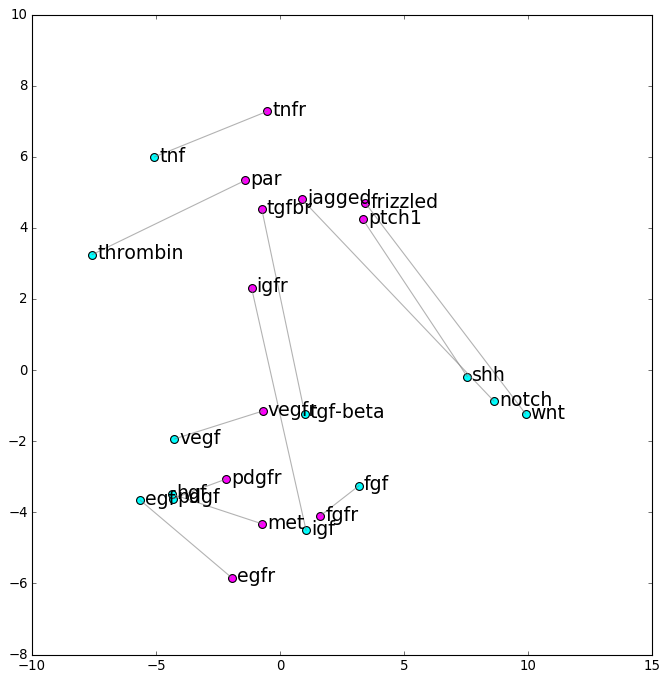

In [545]:
display_pca_scatterplot(w2v_model_big.wv, 
                        ['tgf-beta','shh','egf','vegf','fgf','pdgf','tnf','igf','thrombin','wnt','hgf','notch'],['tgfbr','ptch1','egfr','vegfr','fgfr','pdgfr','tnfr','igfr','par','frizzled','met','jagged'])

#The embedding plots actually look worse than the small model's but the similarity comparisons seem better

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


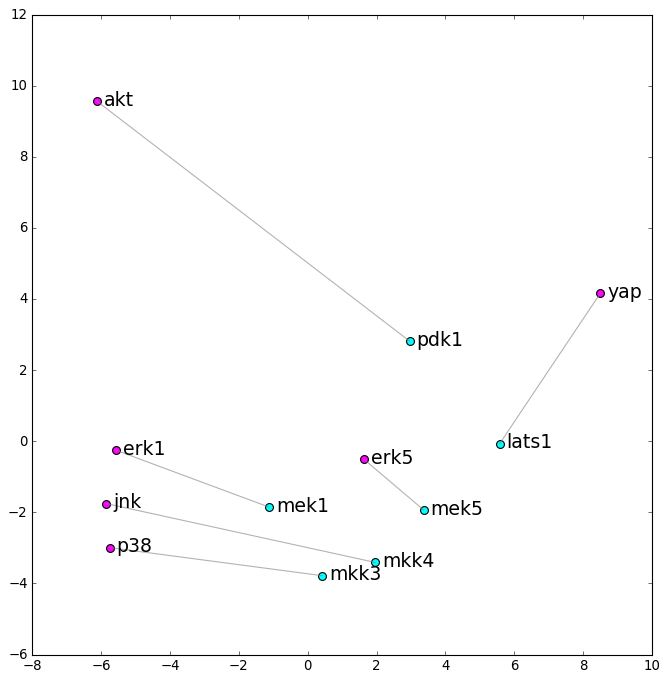

In [546]:
display_pca_scatterplot(w2v_model_big.wv, 
                        ['mek1','pdk1','mkk4','mkk3','mek5','lats1'],['erk1','akt','jnk','p38','erk5','yap'])
#plt.savefig('kinases.jpg')

In [547]:
w2v_model_big.wv.doesnt_match(['covid-19','hiv','herpes','ebv','influenza','bacteria'])

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'bacteria'

In [550]:
w2v_model_big.wv.most_similar(['polar body'])

[('telophase', 0.6308843493461609),
 ('ingression', 0.609361469745636),
 ('midbody', 0.5730581879615784),
 ('midzone', 0.5683845281600952),
 ('sister chromatids', 0.5630143880844116),
 ('prophase', 0.5616185665130615),
 ('metaphase', 0.5536940097808838),
 ('multipolar', 0.5530185699462891),
 ('mitotic spindle', 0.5496146082878113),
 ('bipolar spindle', 0.5443446040153503)]

In [554]:
w2v_model_big.wv.most_similar(['glycosylation'])

[('palmitoylation', 0.6430892944335938),
 ('sialylation', 0.6343014240264893),
 ('glycan', 0.6115437746047974),
 ('oligosaccharide', 0.5595611929893494),
 ('o-glycosylation', 0.555462121963501),
 ('n-glycans', 0.5406732559204102),
 ('sulfation', 0.5313103795051575),
 ('asparagine', 0.5028931498527527),
 ('acetylglucosamine', 0.5019896626472473),
 ('gpi', 0.48525270819664)]

In [569]:
w2v_model.wv.most_similar(['camkii']) #small is less correct than big

[('pka', 0.9156705141067505),
 ('camp-dependent protein kinase', 0.9023529291152954),
 ('protein kinase a', 0.8902258276939392),
 ('pkg', 0.8755244612693787),
 ('epac', 0.8690023422241211),
 ('calcineurin', 0.8674153089523315),
 ('pkc', 0.8632640838623047),
 ('camk', 0.852389931678772),
 ('pkczeta', 0.844325065612793),
 ('protein kinase c', 0.8425184488296509)]

In [570]:
w2v_model_big.wv.most_similar(['camkii']) #big is I think better at these similarity tasks for genes

[('camkiv', 0.7211899757385254),
 ('camk', 0.715903639793396),
 ('calmodulin', 0.6711999773979187),
 ('calcineurin', 0.6641920208930969),
 ('calmodulin-dependent protein kinase ii', 0.6569931507110596),
 ('calmodulin kinase ii', 0.617331862449646),
 ('camki', 0.6167974472045898),
 ('pkg', 0.6160549521446228),
 ('camkk', 0.6150147914886475),
 ('ca2+-calmodulin', 0.6125680208206177)]

In [588]:
w2v_model_big.wv.most_similar(positive=['western'])

[('northern', 0.6696786284446716),
 ('immunoblotte', 0.6364967823028564),
 ('immunoblot', 0.569213330745697),
 ('immunoblotting', 0.559872567653656),
 ('southern', 0.5553878545761108),
 ('elisa', 0.5096964836120605),
 ('immunocytochemistry', 0.497146338224411),
 ('immunofluorescence', 0.4969005584716797),
 ('semiquantitative', 0.47939276695251465),
 ('southwestern', 0.4735323190689087)]

In [590]:
w2v_model_big.wv.most_similar(positive=['pcr'])

[('qpcr', 0.82108074426651),
 ('rt-pcr', 0.6530590653419495),
 ('rtpcr', 0.6132370829582214),
 ('pyrosequencing', 0.6011629104614258),
 ('semiquantitative', 0.584621787071228),
 ('immunoblotting', 0.5660451650619507),
 ('polymerase', 0.5482022166252136),
 ('rt‑qpcr', 0.5480329394340515),
 ('hybridization', 0.5383688807487488),
 ('taqman', 0.5357743501663208)]

In [592]:
w2v_model_big.wv.most_similar(positive=['cytometry'])

[('cytometric', 0.8603966236114502),
 ('cytometer', 0.7364914417266846),
 ('fcm', 0.6797306537628174),
 ('facs', 0.653520941734314),
 ('cytofluorometry', 0.6489604711532593),
 ('cytometrically', 0.6270415186882019),
 ('fluorimetry', 0.6031818985939026),
 ('immunocytochemistry', 0.5956168174743652),
 ('immunoblotting', 0.5922421216964722),
 ('immunoblot', 0.5756295919418335)]

In [595]:
w2v_model_big.wv.most_similar(positive=['ihc'])

[('immunohistochemical', 0.7467094659805298),
 ('immunochemistry', 0.740206241607666),
 ('immunohistochemistry', 0.7382911443710327),
 ('h&e', 0.6897398829460144),
 ('immunohistological', 0.6894999146461487),
 ('tumor sections', 0.6870039701461792),
 ('tissue sections', 0.6688789129257202),
 ('immunostaining', 0.6669307351112366),
 ('immunocytofluorescence', 0.6639153361320496),
 ('histochemical', 0.6617645621299744)]

# Using Word Embeddings for Document Clustering

In [1013]:
with open('docs_for_nmf.pickle', 'rb') as read_file:
    docs = pickle.load(read_file)  

Just using the gene tokens because this seems to work best

In [632]:
docs=[list(map(lambda x: re.sub('_GENE.*','', x),doc)) for doc in docs]

In [1014]:
keep_doc=[doc != [] for doc in docs]

In [695]:
sum(keep_doc)

303650

In [645]:
docs = np.array(docs)[keep_doc]

In [646]:
len(docs)

303650

First I tried using the big Word2Vec embeddings (length=300) but the dimensions were I think too high for K-means 

In [653]:
doc_vectors=[]
for doc in docs:
    vector=np.zeros(300)
    for gene in doc:
        try:
            vector = np.add(w2v_model_big.wv[gene],vector)
        except KeyError:
            vector=np.add(vector,np.zeros(300))
    vector = vector/np.linalg.norm(vector)
    doc_vectors.append(vector)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [654]:
len(doc_vectors)

303650

In [698]:
str(doc_vectors[100].sum()) != 'nan'

False

In [696]:
keep_doc_2 = [str(doc.sum()) != 'nan' for doc in doc_vectors]

In [699]:
len(np.array(doc_vectors)[keep_doc_2])

291850

In [700]:
doc_vectors = np.array(doc_vectors)[keep_doc_2]

In [680]:
from sklearn.cluster import KMeans

In [701]:
inertias = []

for k in np.arange(20, 50, 5):
    km = KMeans(n_clusters=k)
    km.fit(doc_vectors)
    inertias.append(km.inertia_)

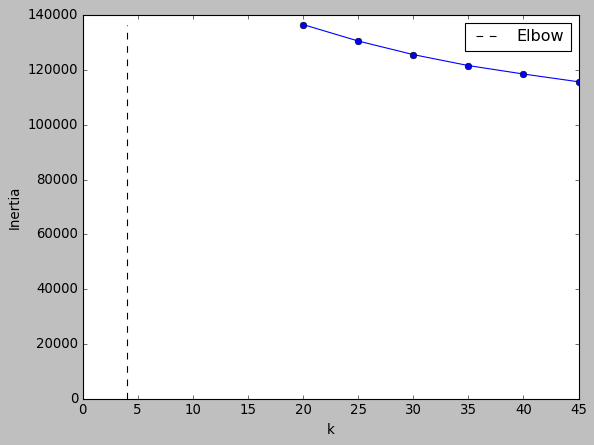

In [704]:
plt.plot(np.arange(20, 50, 5), inertias, marker='o')
plt.vlines(x=4, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend();

This inertia is much higher than k-means in the NMF dimensions..? About 10 times higher. It seems like it is already flattening out as well.  


In [706]:
from collections import Counter

In [707]:
Counter(km.labels_)

Counter({3: 5869,
         0: 7745,
         29: 9915,
         19: 7226,
         36: 8943,
         10: 4736,
         31: 7753,
         34: 4962,
         17: 3553,
         28: 8420,
         9: 5953,
         41: 8014,
         35: 4467,
         43: 3359,
         14: 6914,
         5: 6718,
         11: 2778,
         44: 6442,
         32: 6974,
         12: 5728,
         6: 5007,
         2: 8105,
         42: 4284,
         13: 9964,
         21: 9833,
         30: 3842,
         24: 4664,
         18: 4073,
         27: 4573,
         1: 14405,
         40: 9046,
         7: 6512,
         38: 2825,
         15: 6296,
         4: 7108,
         23: 8250,
         8: 5947,
         26: 3603,
         20: 4291,
         25: 5770,
         16: 14366,
         39: 5736,
         37: 7102,
         22: 4595,
         33: 5184})

maybe Kmeans isn't appropriate because the clusters are different sizes and shapes? Or is the higher inertia because there are 300 dimensions instead of 25? 

### I ended up using the smaller Word2Vec with length=30

In [709]:
doc_vectors=[]
for doc in docs:
    vector=np.zeros(30)
    for gene in doc:
        try:
            vector = np.add(w2v_model.wv[gene],vector)
        except KeyError:
            vector=np.add(vector,np.zeros(30))
    vector = vector/np.linalg.norm(vector)
    doc_vectors.append(vector)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [710]:
keep_doc_2 = [str(doc.sum()) != 'nan' for doc in doc_vectors]

In [711]:
len(np.array(doc_vectors)[keep_doc_2])

291850

In [712]:
doc_vectors = np.array(doc_vectors)[keep_doc_2]

In [713]:
inertias = []

for k in np.arange(20, 50, 5):
    km = KMeans(n_clusters=k)
    km.fit(doc_vectors)
    inertias.append(km.inertia_)

In [715]:
for k in np.arange(50, 80, 5):
    km = KMeans(n_clusters=k)
    km.fit(doc_vectors)
    inertias.append(km.inertia_)

In [ ]:
for k in np.arange(80, 100, ):
    km = KMeans(n_clusters=k)
    km.fit(doc_vectors)
    inertias.append(km.inertia_)

No handles with labels found to put in legend.


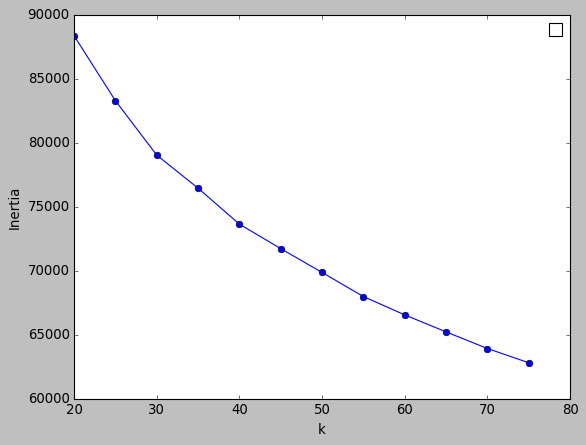

In [717]:
plt.plot(np.arange(20, 80, 5), inertias, marker='o')
#plt.vlines(x=4, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend();

In [818]:
with open('w2v_kmeans_75.pickle','wb') as write_file:
    pickle.dump(km, write_file)

In [728]:
cluster_sizes=Counter(km.labels_)

In [718]:
docs = np.array(docs)

In [719]:
docs = docs[keep_doc]

In [720]:
docs = docs[keep_doc_2]

In [721]:
len(docs)

291850

In [723]:
docs = pd.DataFrame({'genes': docs, 'label':km.labels_})

In [725]:
docs.head()

,genes,label
0,"[neurotensin, neurotensin receptors, neurotensin]",35
1,"[interleukin-2, il-2, antigen, il-2r, il-2, il...",10
2,"[t11 antigen, nkh1, nkh2, nkh1, nkh2, t11 anti...",6
3,"[insulin, alpha, theta and delta]",18
4,"[protein kinase, protein kinase c, pkc, pkc, p...",66


In [729]:
from collections import defaultdict
genes_dict = defaultdict(list)

for i in range(0,80):
    group = docs[docs['label']==i]['genes']
    group = [g.replace("_GENE_OR_GENE_PRODUCT",'') for j in list(group) for g in j]
    genes_dict[i]= pd.Series(group).value_counts()/cluster_sizes[i]*100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [1005]:
topic_labels=["transcriptional reg.","jak/stat","erk/egf","inflam./chemotaxis","insulin/neurotrophic","nueromusclar nmda","leukocyte surface",\
              "p53","wnt/hip.","cAMP","IFNs","wnt/shh","egf/hgf","gtpases","neurodegenerative disease","hdacs/hsp90","2-letter junk",\
              "cftr/gap junctions","insulin","jnk/apoptosis","dna repair","no","locations","tlr","upr/er","ion channels","detox enzymes",\
              "vegf","golgi transport","erk/jnk/nfkb","stemness","bcr","gpcr","bacteria","tcr","hormones","ar/er","jnk",\
              "complement/igg","dates","ecm","bmp","cox2/mmps","akt/survival","protein interaction","egfr/erbb","ubiquitin","pd-1/ctla4","emt","vdr/rxr",\
              "akt/mtor","cAMP/cGMP","integrin","mtor/ampk","hematopoiesis","synapse","tgfb","unclear","nrf2/ros","calcium","rig-i/nlrp3",\
              "junk","intrinsic apoptosis","nfkb","cell cycle","actin","pkc","caspase","extrinsic apoptosis","notch","fibrosis","tnf-a","ras",\
              "platelet","extravasation"]

In [1006]:
genes_dict[0].head(25)

creb                        28.911474
c-jun                       26.825354
hif                         24.659000
sp1                         22.572880
ap-1                        22.091468
c-fos                       21.529821
hif-1alpha                  20.165820
p300                        14.709815
cbp                         13.800481
jun                         12.302755
mitf                        10.163145
nf-κb                        9.922439
cre                          8.371222
smad3                        7.675849
camp                         7.140947
srf                          6.659535
egr-1                        6.499064
hif1α                        6.445574
c-myc                        6.071142
hypoxia-inducible factor     5.964162
foxo1                        5.536240
p53                          5.268788
ebpbeta                      5.001337
histone                      4.974592
jnk                          4.867612
dtype: float64

In [997]:
with open('genes_dict_w2V_75.pickle','wb') as write_file:
    pickle.dump(genes_dict,write_file)

In [803]:
def top_categories(string):
    '''
    Take a gene token string and output it's representation in different clusters
    Representation is (total counts) / (cluster size) * 100
    '''
    output=[]
    for i in range(75):
        try:
            output.append((i,genes_dict[i][string]))
        except:
            continue
    return sorted(output, key=lambda x: x[1], reverse=True)

In [1004]:
top_categories('drosha')

[(57, 0.5612998522895126),
 (14, 0.42720999014130795),
 (46, 0.3588516746411483),
 (30, 0.34080717488789236),
 (56, 0.10254306808859721),
 (64, 0.07129277566539924),
 (8, 0.029958058717795086),
 (48, 0.028901734104046246),
 (24, 0.027337342810278838),
 (0, 0.02674511901577962),
 (9, 0.02533569799847986),
 (67, 0.014697236919459141),
 (37, 0.01417836381681554)]

In [930]:
from sklearn.manifold import TSNE

In [928]:
cluster_centers = km.cluster_centers_

In [937]:
cluster_sizes = pd.Series(Counter(km.labels_)).sort_index()

In [968]:
clusters_embedded = TSNE(n_components=2, learning_rate=10, perplexity=30,n_iter=5000).fit_transform(cluster_centers)

In [991]:
with open('tsne_points_for_75_w2v_clusters.pickle','wb') as write_file:
    pickle.dump(clusters_embedded, write_file)

In [969]:
x = [i[0] for i in clusters_embedded]

In [970]:
y = [i[1] for i in clusters_embedded]

In [935]:
cluster_colors=np.arange(0,75)

Text(0, 0.5, 'tSNE dimension 2')

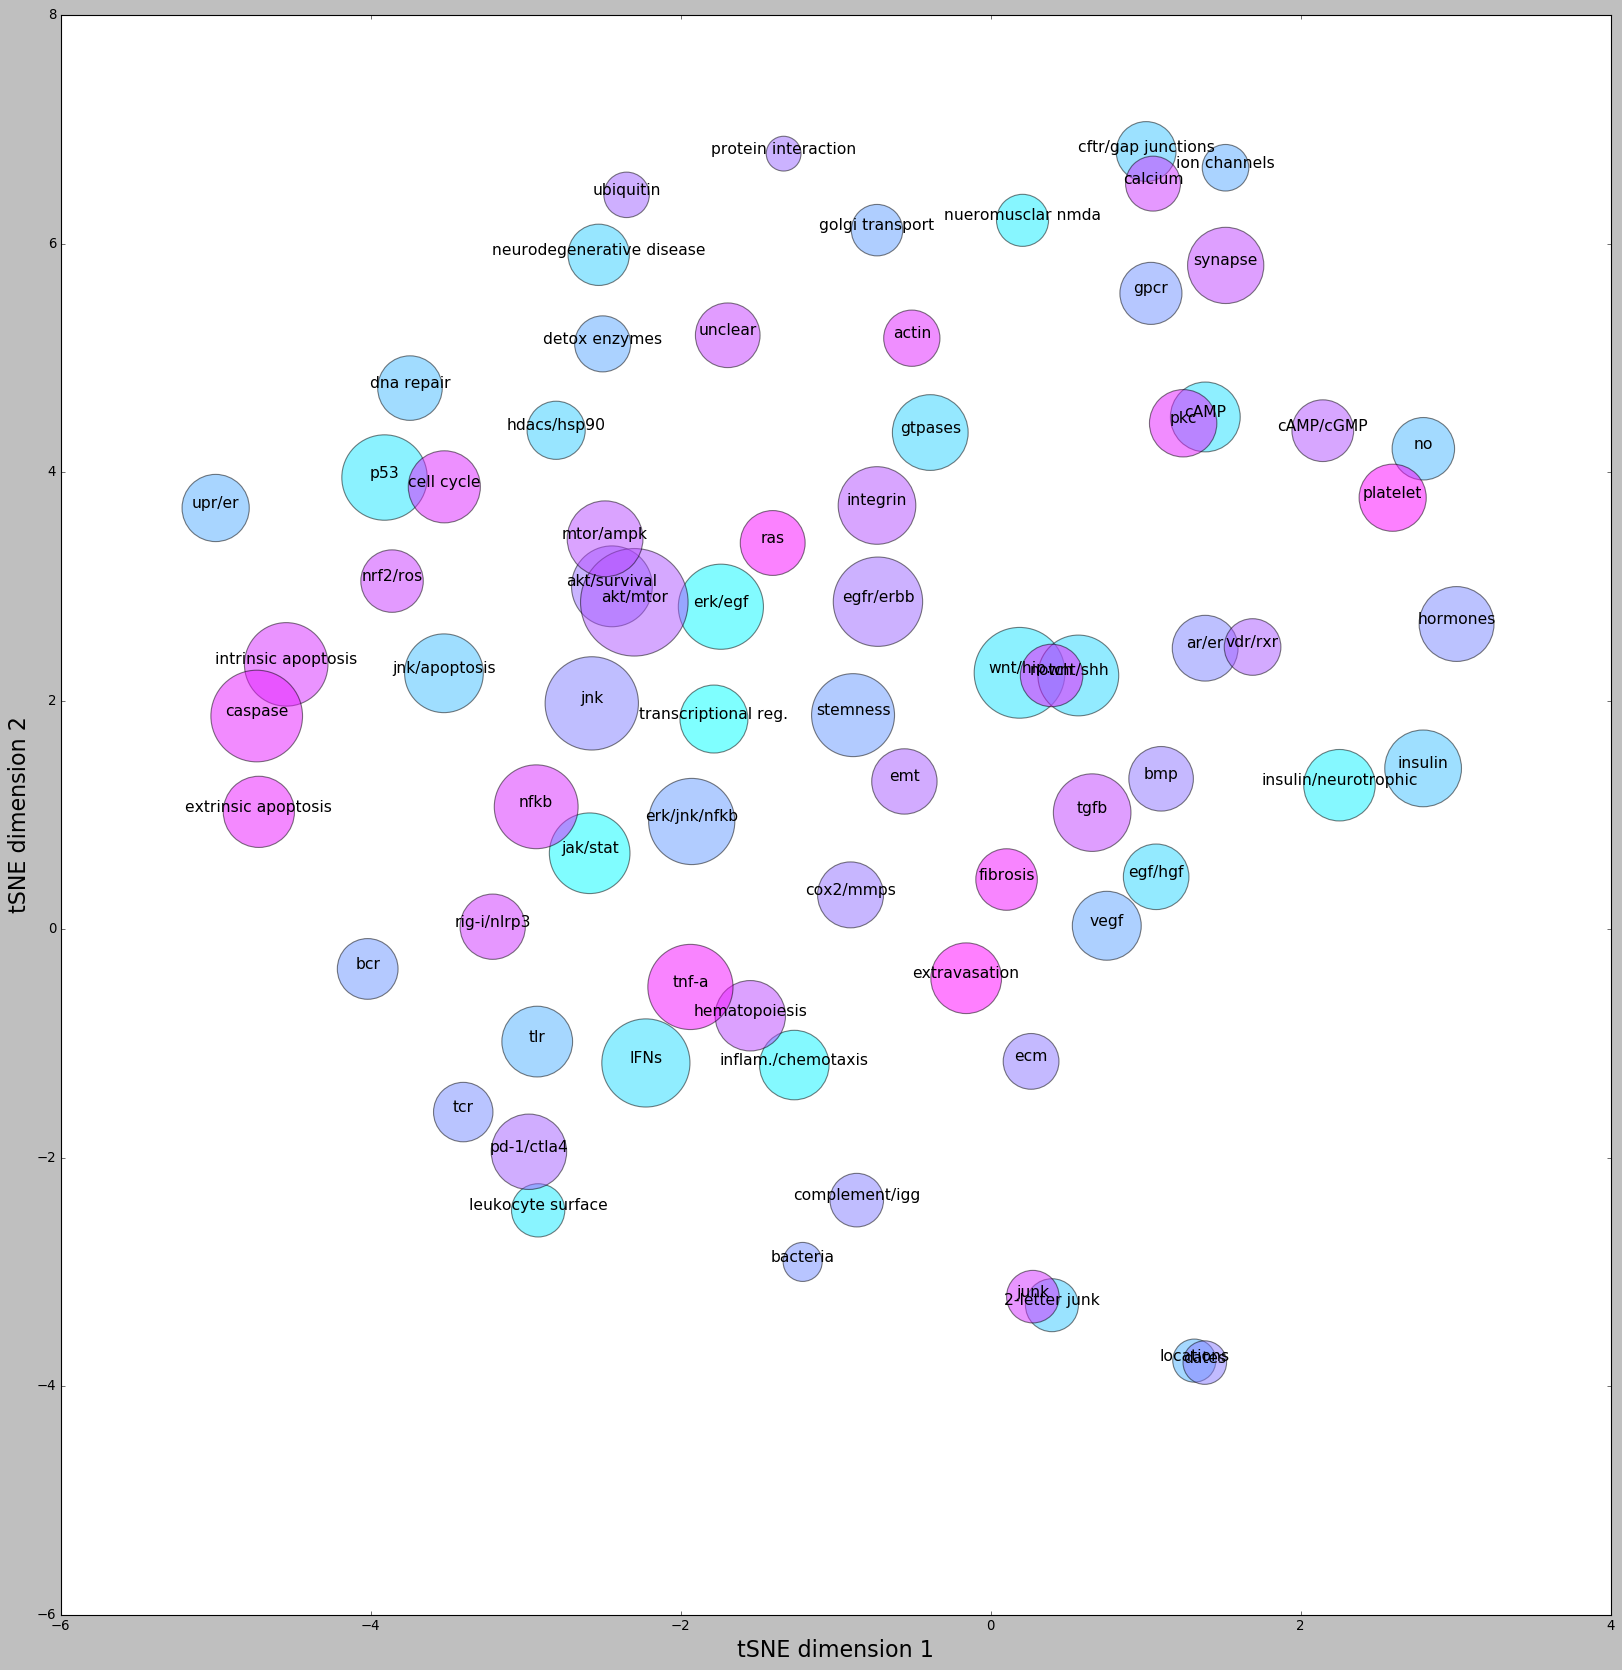

In [1007]:
plt.figure(figsize=(25,25))
plt.scatter(x,y, 
            c = cluster_colors, s=(cluster_sizes), cmap="cool", alpha=0.5)
i=-1
for x_lab,y_lab in zip(x,y):
    i +=1
    plt.annotate(topic_labels[i],(x_lab,y_lab), ha="center", fontsize=14)

plt.xlabel('tSNE dimension 1',fontsize=20)
plt.ylabel('tSNE dimension 2', fontsize=20)

#plt.savefig('tSNE_w2v.jpg')

Getting the other non-gene tokens for these clusters as well

In [1009]:
with open('docs_annotated_ner.pickle', 'rb') as read_file:
    docs_ner = pickle.load(read_file)

In [1010]:
docs_other = []
for doc in docs_ner:
    docs_other.append([t for t in doc if (t.find("GENE") == -1) and (t.startswith('doi_') != True) and t.startswith('usa_') != True and t.startswith('boston_') != True and t.startswith("uk_") != True and t.startswith('gfp_') != True and t.startswith('luciferase_') != True and t.startswith('/_') != True and t.startswith('e.g._') != True and t.startswith('microm.') != True ])

In [1017]:
docs_other = np.array(docs_other)[keep_doc]

In [1018]:
docs_other = docs_other[keep_doc_2]

In [1019]:
len(docs_other)

291850

In [1021]:
docs_other = pd.DataFrame({'other': docs_other, 'label':km.labels_})

In [1026]:

other_dict = defaultdict(list)

for i in range(0,75):
    group = docs_other[docs_other['label']==i]['other']
    group = [re.sub("_.*",'',g) for j in list(group) for g in j]
    other_dict[i]= pd.Series(group).value_counts()/cluster_sizes[i]*100

In [1032]:
other_dict[74].head(20)

cell                    189.775253
tumor                    34.033095
platelet                 26.994320
cellular                 23.610768
cancer                   20.968140
extracellular matrix     20.696468
leukocyte                18.597184
patient                  17.115337
tissue                   16.720178
intracellular            15.584095
mouse                    14.546802
ecm                      13.731786
endothelial cells        13.188442
neutrophil               11.830082
cell surface             11.632502
matrix                   11.286737
membrane                 11.015065
human                    10.224747
cytoplasmic               9.953075
tyrosine                  9.138059
dtype: float64

In [1033]:
with open('other_dict_w2v_75.pickle','wb') as write_file:
    pickle.dump(other_dict,write_file)